<a href="https://colab.research.google.com/github/hunterschep/CS2-homeworks/blob/main/NLLB_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is based on [this Medium post](https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865) and its [associated Colab notebook](https://colab.research.google.com/drive/1bayEaw2fz_9Mhg9jFFZhrmDlQlBj1YZf?usp=sharing).

[Here's a link to the data](https://drive.google.com/drive/folders/1Zpwbbub_Q9L2QIRBNM10GoFHtvJlSMK7?usp=sharing
), which is just a parallel Bible corpus for Amis and English:




# 0. Preliminaries

Mount your Google Drive, which I mount in the cell below.

In [63]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [64]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [65]:
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q

# 1. Exploring the data

In this section, I try to understand what is the training data that I have, and how suitable it is for fine-tuning a NLLB model.

In [82]:
import csv
import re

def remove_punct(s):
    # Remove square brackets
    s = re.sub(r"\[|\]", "", s)
    # Replace special circumflex accent with space
    s = re.sub(r"⌃", " ", s)
    # Handle em dashes explicitly
    s = re.sub(r"—", " ", s)
    # General punctuation cleanup
    s = re.sub(r"[\.\,\?\!\<\>;\:\’\‘]", "", s)  # Update to include colons and semicolons
    s = re.sub(r'["”“]', "", s)  # Remove double quotes
    s = re.sub(r'[‘’`]', "'", s)  # Standardize single quotes
    s = re.sub(r"-", " ", s)  # Replace hyphens with space
    # Convert to lowercase
    s = s.lower()
    return s


counter = 1
ami_eng = []
with open('/content/drive/MyDrive/local_mt/fine_tuned/amis-english.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    next(csv_reader)  # Skip the header if present; remove this line if no header
    for row in csv_reader:
        if counter % 10 == 0:
            partition = "test"
        elif counter % 5 == 0:
            partition = "dev"
        else:
            partition = "train"
        # Since there are only two columns, use row[0] for Amis and row[1] for English
        addme = [counter, counter, remove_punct(row[0]).rstrip(), remove_punct(row[1]), partition]
        ami_eng.append(addme)
        counter += 1

print(ami_eng[20])


[21, 21, 'o kadofahay a serangawan ato taneng i marayrayay to itini', 'but we only know to write history from the perspective of the dominant', 'train']


In [83]:
import pandas as pd
trans_df = pd.DataFrame(ami_eng)
trans_df.columns = ["row_id",	"ind", "ami",	"eng",	"split"]

pd.options.display.max_colwidth = 100

In [84]:
trans_df.head(10)

,row_id,ind,ami,eng,split
0,1,1,i aayaw no 22 a mihecaan no nini a romiad i mafalicto a matongal ko rikec no mita to san paw san...,on this day 22 years ago the term shanbao (mountain people) in the additional articles of our co...,train
1,2,2,onini i o palasawaday to misawiliay misakakinihay konini a ngangan ato pasifanaay a pahapinang a...,this correction not only did away with a discriminatory term but also highlighted the status of ...,train
2,3,3,itini tona parenaan a tomireng ta mangaay miawas kita a tala aayaw anini,from this basis today we are taking another step forward,train
3,4,4,komod han no mako ko cen fu a mitaong to polong no yin cu min cu a paini to ngodo^ no faloco no ...,to all indigenous peoples of taiwan on behalf of the government i express to you our deepest apo...,train
4,5,5,400 a mihcaan to ko pades ato masakakinih ko polong namo na onian saka komod a han no mako ko ce...,for the four centuries of pain and mistreatment you have endured i apologize to you on behalf of...,dev
5,6,6,pasoelin kako tangasa anini i taliyok no orip ako i iray ho ko hamaan a taongen sanay a tamdaw,i know that even now there are some around us who see no need to apologize,train
6,7,7,onini ko satadamaanay a demak no mako anini a komod to cen fu a mitaong,but that is the most important reason why i am representing the government to issue this apology...,train
7,8,8,oya palangaayay sanay to misakakinihay a demak ano ca o heci no saka comahad no tamdamdaw ko ror...,to see what was unfair in the past as a matter of course or to treat the pain of other ethnic pe...,train
8,9,9,sakameden ako ko sowal a paini nawiro mitaong kako to yin cu min cu,let me put in simple terms why we are apologizing to the indigenous peoples,train
9,10,10,onini a pala^ i taywan i ayaw no 400 a mihcaan iraayto ko maroay a tamdaw,four hundred years ago there were already people living in taiwan,test


In [85]:
trans_df.isnull().sum()

row_id    0
ind       0
ami       0
eng       0
split     0
dtype: int64

In [86]:
trans_df.split.value_counts()

split
train    41926
dev       5241
test      5240
Name: count, dtype: int64

In [87]:
df_train = trans_df[trans_df.split=='train'].copy() #
df_dev = trans_df[trans_df.split=='dev'].copy()     #
df_test = trans_df[trans_df.split=='test'].copy()   #

# 2. How well does the data fit into a NLLB tokenizer?

In [88]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [89]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')

In [90]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [91]:
#smpl = df_train.sample(10000, random_state=1)

smpl = df_train

smpl['eng_toks'] = smpl.eng.apply(tokenizer.tokenize)
smpl['ami_toks'] = smpl.ami.apply(tokenizer.tokenize)

smpl['eng_words'] = smpl.eng.apply(word_tokenize)
smpl['ami_words'] = smpl.ami.apply(word_tokenize)

In [92]:
smpl.sample(5)[['ami', 'ami_words', 'ami_toks', 'eng', 'eng_words', 'eng_toks']]

,ami,ami_words,ami_toks,eng,eng_words,eng_toks
14516,rasa,[rasa],[▁rasa],consequently,[consequently],"[▁consequ, ently]"
49552,owah o wawa ako sakakaay,"[owah, o, wawa, ako, sakakaay]","[▁o, wah, ▁o, ▁wawa, ▁ako, ▁sak, aka, ay]",it's my oldest child,"[it, ', s, my, oldest, child]","[▁it, ', s, ▁my, ▁old, est, ▁child]"
40312,hay makaʼen no cilahhay caʼay kasanek ko siraw sa,"[hay, makaʼen, no, cilahhay, caʼay, kasanek, ko, siraw, sa]","[▁hay, ▁maka, ʼ, en, ▁no, ▁ci, lah, hay, ▁ca, ʼ, ay, ▁kasan, ek, ▁ko, ▁sira, w, ▁sa]",that way the salt will penetrate it won't smell,"[that, way, the, salt, will, penetrate, it, won, ', t, smell]","[▁that, ▁way, ▁the, ▁salt, ▁will, ▁pen, etr, ate, ▁it, ▁won, ', t, ▁smell]"
25726,i loma sato i tala sa to tayniay minokay sato i maranam to,"[i, loma, sato, i, tala, sa, to, tayniay, minokay, sato, i, maranam, to]","[▁i, ▁loma, ▁sato, ▁i, ▁tala, ▁sa, ▁to, ▁tay, ni, ay, ▁min, ok, ay, ▁sato, ▁i, ▁mar, anam, ▁to]",if you're at home they're waiting when we get back we'll have breakfast,"[if, you, ', re, at, home, they, ', re, waiting, when, we, get, back, we, ', ll, have, breakfast]","[▁if, ▁you, ', re, ▁at, ▁home, ▁they, ', re, ▁waiting, ▁when, ▁we, ▁get, ▁back, ▁we, ', ll, ▁hav..."
6278,mikiskis ci mama to cikaf no foting,"[mikiskis, ci, mama, to, cikaf, no, foting]","[▁mik, isk, is, ▁ci, ▁mama, ▁to, ▁cika, f, ▁no, ▁fot, ing]",dad scales the fish,"[dad, scales, the, fish]","[▁dad, ▁sca, les, ▁the, ▁fish]"


In [93]:
stats = smpl[['eng_toks', 'ami_toks', 'eng_words', 'ami_words']].applymap(len).describe()
stats

,eng_toks,ami_toks,eng_words,ami_words
count,41926.000000,41926.000000,41926.000000,41926.00000
mean,9.152316,10.704742,8.074655,6.67538
std,5.720760,7.206166,5.003294,4.32162
min,0.000000,0.000000,0.000000,0.00000
25%,5.000000,6.000000,5.000000,4.00000
50%,8.000000,9.000000,7.000000,6.00000
75%,11.000000,13.000000,10.000000,8.00000
max,106.000000,138.000000,94.000000,76.00000


In [94]:
print(stats.eng_toks['mean'] / stats.eng_words['mean'])
print(stats.ami_toks['mean'] / stats.ami_words['mean'])

1.1334621224205257
1.603615224102447


In [95]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


Good news: both for English and Amis, the NLLB tokenizer seems to produce around 2 tokens per word (more precisely, 2.3 and 1.8), which means that the translation quality of fine-tuned NLLB may be decent even without vocabulary extension.

One more check: how often does the <unk> token happen in the tokenizer output for Amis? If this is too often, we need to fix it somehow

In [96]:
texts_with_unk = [text for text in tqdm(trans_df.ami) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/52407 [00:00<?, ?it/s]

3


In [98]:
### If you get anything larger than 5 above, you can run this code to see what the unknown tokens are

import random
s = random.sample(texts_with_unk, 2)
print(s)

['icikil 81–1914 milengoay to kaholiw saka enem a mihecaan o ˈayaw ni yis 612 mihecaan', 'o roma mihongyakan a fangcalay cudad iraay ko sinael no yohani 753–811 kawra cowa ka fanaˈ ko ˈalomanay to patongalan koniya sinael cowa ko soˈlinay']


Apparently, most of the texts with 3634 unknown tokens just have some punctuation unfamiliar to the NLLB tokenizer.

This is because the NLLB model was pretrained on normalized texts. If we reproduce the normalization, most of the problems would be fixed.

In [99]:
# I didn't actually run this code because we didn't have any unknown tokens after all the normalization.

# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang="en")
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [100]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

  0%|          | 0/3 [00:00<?, ?it/s]

1


Indeed, after normalizing texts, none of them contain unknown tokens. We will use this as one more piece of evidence that we don't have to update the tokenizer vocabulary to use it with Amis.

# 3 (optional). Expanding the vocabulary

# 4. Adding a new language tag to the tokenizer and model

In [101]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [102]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256202, 256203]))

256204
['zul_Latn', '<mask>']


In [103]:
def fix_tokenizer(tokenizer, new_lang='ami_Latn'):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [104]:
fix_tokenizer(tokenizer)

In [105]:
print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zulLatn', 'ami_Latn', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'ami_Latn', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', 'ami_Latn', '<mask>']
[256202, 256203, 256204]


In [106]:
added_token_id = tokenizer.convert_tokens_to_ids('ami_Latn')
similar_lang_id = tokenizer.convert_tokens_to_ids('tgl_Latn')
print(added_token_id, similar_lang_id)

256203 256174


In [107]:
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-600M')
model.resize_token_embeddings(len(tokenizer))

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 256205. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(256205, 1024)

In [108]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

# 5. Preparing the training loop

In [109]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [110]:
model.cuda();

In [111]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [112]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 500
training_steps = 5000

In [113]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [114]:
LANGS = [('eng', 'eng_Latn'), ('ami', 'ami_Latn')]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))


(['let youth leaders punish disobedient youth'], ['papitefocen ko mama no kapah to caayay pitengil a kapah'], 'eng_Latn', 'ami_Latn')


In [115]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/local_mt/fine_tuned/nllb-eng-ami-v1'

# 6. The training loop

In [116]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/5000 [00:00<?, ?it/s]

0 8.65564250946045
1000 4.024448306322098
2000 3.129059204697609
3000 2.8648223568201066
4000 2.6512324315309526


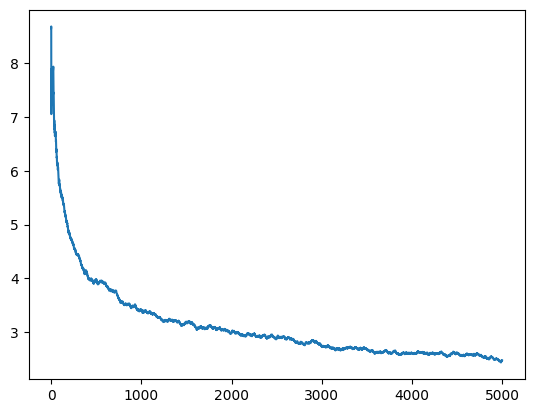

In [117]:
pd.Series(losses).ewm(100).mean().plot();

# We continue

You can see that the loss is going down a lot each time, so I expect if I had continued to train, I would have seen additional losses.

You can refer to the notebook, and figure out what comes next for applying and evaluating the model. Please note that:


* rus_Cyrl in the original notebook becomes eng_Latn here
* tyv_Cyrl in the original notebook becomes ami_Latn here

The original medium post and notebook assume there's extra data to translate which we don't have. I think the easiest thing to do at first will be to get training to run all the way through, and then to get the output of the test set, and then evaluate that with BLEU and chrF.

In [118]:
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM
model_load_name = '/content/drive/MyDrive/local_mt/fine_tuned/nllb-eng-ami-v1'
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name).cuda()
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [124]:
import pandas as pd
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM
from torch.utils.data import DataLoader, Dataset

# Define a simple dataset for handling our data within PyTorch
class TranslationDataset(Dataset):
    def __init__(self, texts, tokenizer, max_length=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        inputs = self.tokenizer(text, max_length=self.max_length, truncation=True, padding='max_length', return_tensors="pt")
        return inputs

# Load the trained model and tokenizer
model_path = '/content/drive/MyDrive/local_mt/fine_tuned/nllb-eng-ami-v1'
tokenizer = NllbTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path).cuda()

# Sample 20 entries from the training set
sample_data = df_train.sample(20, random_state=1)
texts = sample_data['ami'].tolist()
actual_translations = sample_data['eng'].tolist()

# Prepare the dataset and dataloader
dataset = TranslationDataset(texts, tokenizer)
dataloader = DataLoader(dataset, batch_size=1)

# Model into evaluation mode
model.eval()

# Predict translations
predicted_translations = []
for batch in dataloader:
    input_ids = batch['input_ids'].squeeze(0).cuda()  # Ensure batch dimension exists
    attention_mask = batch['attention_mask'].squeeze(0).cuda()

    with torch.no_grad():
        outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=128)

    pred_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    predicted_translations.append(pred_text)

# Compare predicted translations to actual translations
for actual, predicted in zip(actual_translations, predicted_translations):
    print(f"Actual: {actual}\nPredicted: {predicted}\n")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Actual: i am convicted (from hearing)
Predicted: ma'emangay ko faloco' ako

Actual: all have
Predicted: ira amin

Actual: in the morning when we're about to leave
Predicted: o dafak to to toʼas to toʼas to

Actual: look at it it's just like this piece of meat
Predicted: o no record

Actual: it's different in danshui
Predicted: anini to i o nanom ko sowal ako

Actual: right at the mouth of the river
Predicted: itila i sakamod niya sowac tarawadaw

Actual: mom dad okay i'm going to the army
Predicted: hay ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina ina